In [188]:
import pandas as pd
import numpy as np
import pickle
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from datetime import datetime
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [2]:
dateparse = lambda x: datetime.strptime(x, '%Y/%m/%d') if isinstance(x, str) else x

In [42]:
# Load the data
data = pd.read_excel('SignedPlayersDatasetVALORANT.xlsx', parse_dates=['date'], date_parser=dateparse)
# Fix name errors
data = data.replace('\n','', regex=True)
data = data.replace(' ','', regex=True)
#test_data = pd.read_excel('Test Dataset VALORANT VCT DATASET.xlsx', parse_dates=['date'], date_parser=dateparse).dropna(how='any',axis=0)

In [43]:
# Select features and target variable
input_features = ['date', 'player']
features = ['kills_per_round', 'assists_per_round', 'average_damage_per_round',
            'first_kills_per_round', 'first_deaths_per_round', 'headshot_percentage',
            'clutch_success_percentage', 'total_kills', 'total_deaths', 'total_assists',
            'total_first_kills', 'total_first_deaths']
target_variable = 'average_combat_score'
#Note: create models w/ target variable for rounds and rating

In [44]:
"""
# Split variables
X_train = data[features]
X_test = test_data[features]
y_train = data[target_variable]
y_test = test_data[target_variable]
"""

'\n# Split variables\nX_train = data[features]\nX_test = test_data[features]\ny_train = data[target_variable]\ny_test = test_data[target_variable]\n'

In [45]:
dates = data['date'].unique()

In [46]:
players = data['player'].unique()

In [47]:
def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month

def months_from_2021(dates):
    months_from_Jan_2021 = []
    for date in dates:
        months_from_Jan_2021.append(diff_month(date, datetime.strptime('2021/01/01', '%Y/%m/%d')))
    return months_from_Jan_2021

In [48]:
data = data.assign(months_from_Jan_2021 = months_from_2021(data['date']))

In [115]:
#Create regression model for each feature for each players
#Note: Unknown players don't work.
#Note: Used decision tree regression due to small sample per player. Problem stops predicting past latest event
player_feature_models = {}
for player in players:
    player_feature_model = {}
    player_data = data.loc[data['player'] == player]
    for feature in features:
        feature_model = DecisionTreeRegressor(max_depth=3).fit(player_data['months_from_Jan_2021'].values[:,np.newaxis], player_data[feature])
        player_feature_model.update({feature:feature_model})
    player_feature_models.update({player:player_feature_model})

In [116]:
#Create regression model for each feature for each players
#Note: Unknown players don't work.
#Note: Used decision tree regression due to problems in prediction. Can cause negative values
player_feature_models_linear = {}
for player in players:
    player_feature_model = {}
    player_data = data.loc[data['player'] == player]
    for feature in features:
        feature_model = LinearRegression().fit(player_data['months_from_Jan_2021'].values[:,np.newaxis], player_data[feature])
        player_feature_model.update({feature:feature_model})
    player_feature_models_linear.update({player:player_feature_model})

In [122]:
#Create regression model for each feature for each players
#Note: Unknown players don't work.
#Note: XGboost models can get very heavy in file size
player_feature_models_XGB = {}
for player in players:
    player_feature_model = {}
    player_data = data.loc[data['player'] == player]
    for feature in features:
        feature_model = XGBRegressor().fit(player_data['months_from_Jan_2021'].values[:,np.newaxis], player_data[feature])
        player_feature_model.update({feature:feature_model})
    player_feature_models_XGB.update({player:player_feature_model})

In [117]:
#Save Models
filename = 'player_feature_models.sav'
pickle.dump(player_feature_models, open(filename, 'wb'))

In [118]:
filename = 'player_feature_models_linear.sav'
pickle.dump(player_feature_models_linear, open(filename, 'wb'))

In [123]:
filename = 'player_feature_models_XGB.sav'
pickle.dump(player_feature_models_XGB, open(filename, 'wb'))

In [119]:
#Load models
ACSmodelfilename = 'model w tuning.sav'
featuremodeltreefilename = 'player_feature_models.sav'
featuremodellinearfilename = 'player_feature_models_linear.sav'

model = pickle.load(open(ACSmodelfilename, 'rb'))

In [120]:
#Note: load model to be used
player_feature_models = pickle.load(open(featuremodeltreefilename, 'rb'))

In [74]:
def predict_player_feature(player, date, feature):
    date_array = [dateparse(date)]
    date_from_Jan_2021 = months_from_2021(date_array)
    return player_feature_models.get(player).get(feature).predict(np.array([date_from_Jan_2021]))[0]

In [75]:
def predict_players_values(players_and_dates):
    players_and_dates = players_and_dates.assign(months_from_Jan_2021 = months_from_2021(players_and_dates['date']))
    player_predicted_values = pd.DataFrame()
    for feature in features:
        player_values = []
        for player_and_date in players_and_dates.itertuples():
            player_values.append(predict_player_feature(player_and_date.player, player_and_date.date, feature))
        player_predicted_values[feature] = player_values
    return pd.DataFrame(player_predicted_values)

In [76]:
#Predict ACS
def predictACS(players_and_dates):
    return model.predict(predict_players_values(players_and_dates))

In [77]:
#Player predictions on date
#Note: Use pandas dataframe on this. 
def playerStatPredictions(players_and_dates):
    players_predictions = players_and_dates.copy()
    players_predictions = pd.merge(players_predictions, predict_players_values(players_and_dates), left_index=True, right_index=True)
    players_predictions['average_combat_score'] = predictACS(players_and_dates)
    return players_predictions

In [106]:
#All players in dates
def all_players_date(dates_used):
    index = pd.MultiIndex.from_product([players, dates_used], names = ["player", "date"])
    players_dates_pd = pd.DataFrame(index = index).reset_index()
    players_dates_pd['date'] = pd.to_datetime(players_dates_pd['date'])
    return players_dates_pd

In [121]:
#Test tree model
model_mse = pd.DataFrame()
prediction_features = predict_players_values(data[['player', 'date']])
prediction_ACS = predictACS(data[['player', 'date']])
model_mse['ACS_mse'] = [mean_squared_error(data['average_combat_score'], prediction_ACS)]
for feature in features:
    model_mse[feature + '_mse'] = [mean_squared_error(data[feature], prediction_features[feature])]
model_mse

,ACS_mse,kills_per_round_mse,assists_per_round_mse,average_damage_per_round_mse,first_kills_per_round_mse,first_deaths_per_round_mse,headshot_percentage_mse,clutch_success_percentage_mse,total_kills_mse,total_deaths_mse,total_assists_mse,total_first_kills_mse,total_first_deaths_mse
0,60.203662,0.000474,0.000245,16.852039,0.000058,0.000042,0.000078,0.000753,201.661483,140.705742,59.518142,5.880183,8.216906


In [145]:
#Predict Missing values
all_players_dates_pd = all_players_date(dates)
all_data = all_players_dates_pd.merge(data, on=['player', 'date'], how='left')
all_data

,player,date,rounds,rating,average_combat_score,kills_deaths,average_damage_per_round,kills_per_round,assists_per_round,first_kills_per_round,first_deaths_per_round,headshot_percentage,clutch_success_percentage,total_kills,total_deaths,total_assists,total_first_kills,total_first_deaths,months_from_Jan_2021
0,Cryocells,2022-10-07,119.0,1.22,249.6,1.39,158.8,0.89,0.11,0.15,0.06,0.24,0.06,106.0,76.0,13.0,18.0,7.0,21.0
1,Cryocells,2022-08-31,285.0,1.15,232.2,1.27,143.4,0.85,0.13,0.18,0.13,0.24,0.19,242.0,191.0,36.0,50.0,36.0,19.0
2,Cryocells,2023-02-13,175.0,1.00,219.3,1.01,137.5,0.75,0.25,0.13,0.18,0.18,0.00,131.0,130.0,54.0,23.0,32.0,25.0
3,Cryocells,2021-09-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Cryocells,2023-11-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,hoody,2023-11-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
896,hoody,2023-06-08,161.0,1.04,204.6,1.00,139.0,0.70,0.46,0.10,0.12,0.23,0.12,113.0,113.0,74.0,16.0,19.0,29.0
897,hoody,2021-12-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
898,hoody,2021-05-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [174]:
missing_data = all_data[pd.isna(all_data['average_combat_score'])].reset_index(drop=True)

In [175]:
missing_data[['player', 'date']]

,player,date
0,Cryocells,2021-09-19
1,Cryocells,2023-11-06
2,Cryocells,2023-06-08
3,Cryocells,2021-12-12
4,Cryocells,2021-05-30
...,...,...
477,hoody,2022-08-31
478,hoody,2021-09-19
479,hoody,2023-11-06
480,hoody,2021-12-12


In [176]:
missing_data_predict = playerStatPredictions(missing_data[['player', 'date']])

In [185]:
all_data_w_predict = all_data.set_index(['player', 'date']).combine_first(missing_data_predict.set_index(['player', 'date'])).reset_index()

In [186]:
all_data_w_predict

,player,date,assists_per_round,average_combat_score,average_damage_per_round,clutch_success_percentage,first_deaths_per_round,first_kills_per_round,headshot_percentage,kills_deaths,kills_per_round,months_from_Jan_2021,rating,rounds,total_assists,total_deaths,total_first_deaths,total_first_kills,total_kills
0,ANGE1,2021-05-30,0.28,157.109528,106.5,0.10,0.15,0.08,0.31,NaN,0.53,NaN,NaN,NaN,99.0,276.0,53.0,27.0,189.0
1,ANGE1,2021-09-19,0.28,157.109528,106.5,0.10,0.15,0.08,0.31,NaN,0.53,NaN,NaN,NaN,99.0,276.0,53.0,27.0,189.0
2,ANGE1,2021-12-12,0.28,157.109528,106.5,0.10,0.15,0.08,0.31,NaN,0.53,NaN,NaN,NaN,99.0,276.0,53.0,27.0,189.0
3,ANGE1,2022-08-31,0.28,159.600000,106.5,0.10,0.15,0.08,0.31,0.68,0.53,19.0,0.75,357.0,99.0,276.0,53.0,27.0,189.0
4,ANGE1,2022-10-04,0.28,173.618927,116.1,0.11,0.16,0.10,0.30,NaN,0.59,NaN,NaN,NaN,154.0,413.0,86.0,58.0,325.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,zekken,2022-10-04,0.22,239.418854,158.0,0.07,0.14,0.14,0.23,NaN,0.82,NaN,NaN,NaN,26.0,87.0,17.0,17.0,97.0
896,zekken,2022-10-07,0.22,241.600000,158.0,0.07,0.14,0.14,0.23,1.11,0.82,21.0,1.09,119.0,26.0,87.0,17.0,17.0,97.0
897,zekken,2023-02-13,0.28,138.500000,77.3,0.00,0.13,0.10,0.24,0.47,0.38,25.0,0.60,39.0,10.0,30.0,4.0,1.0,16.0
898,zekken,2023-06-08,0.28,135.343216,77.3,0.00,0.13,0.10,0.24,NaN,0.38,NaN,NaN,NaN,10.0,30.0,4.0,1.0,16.0


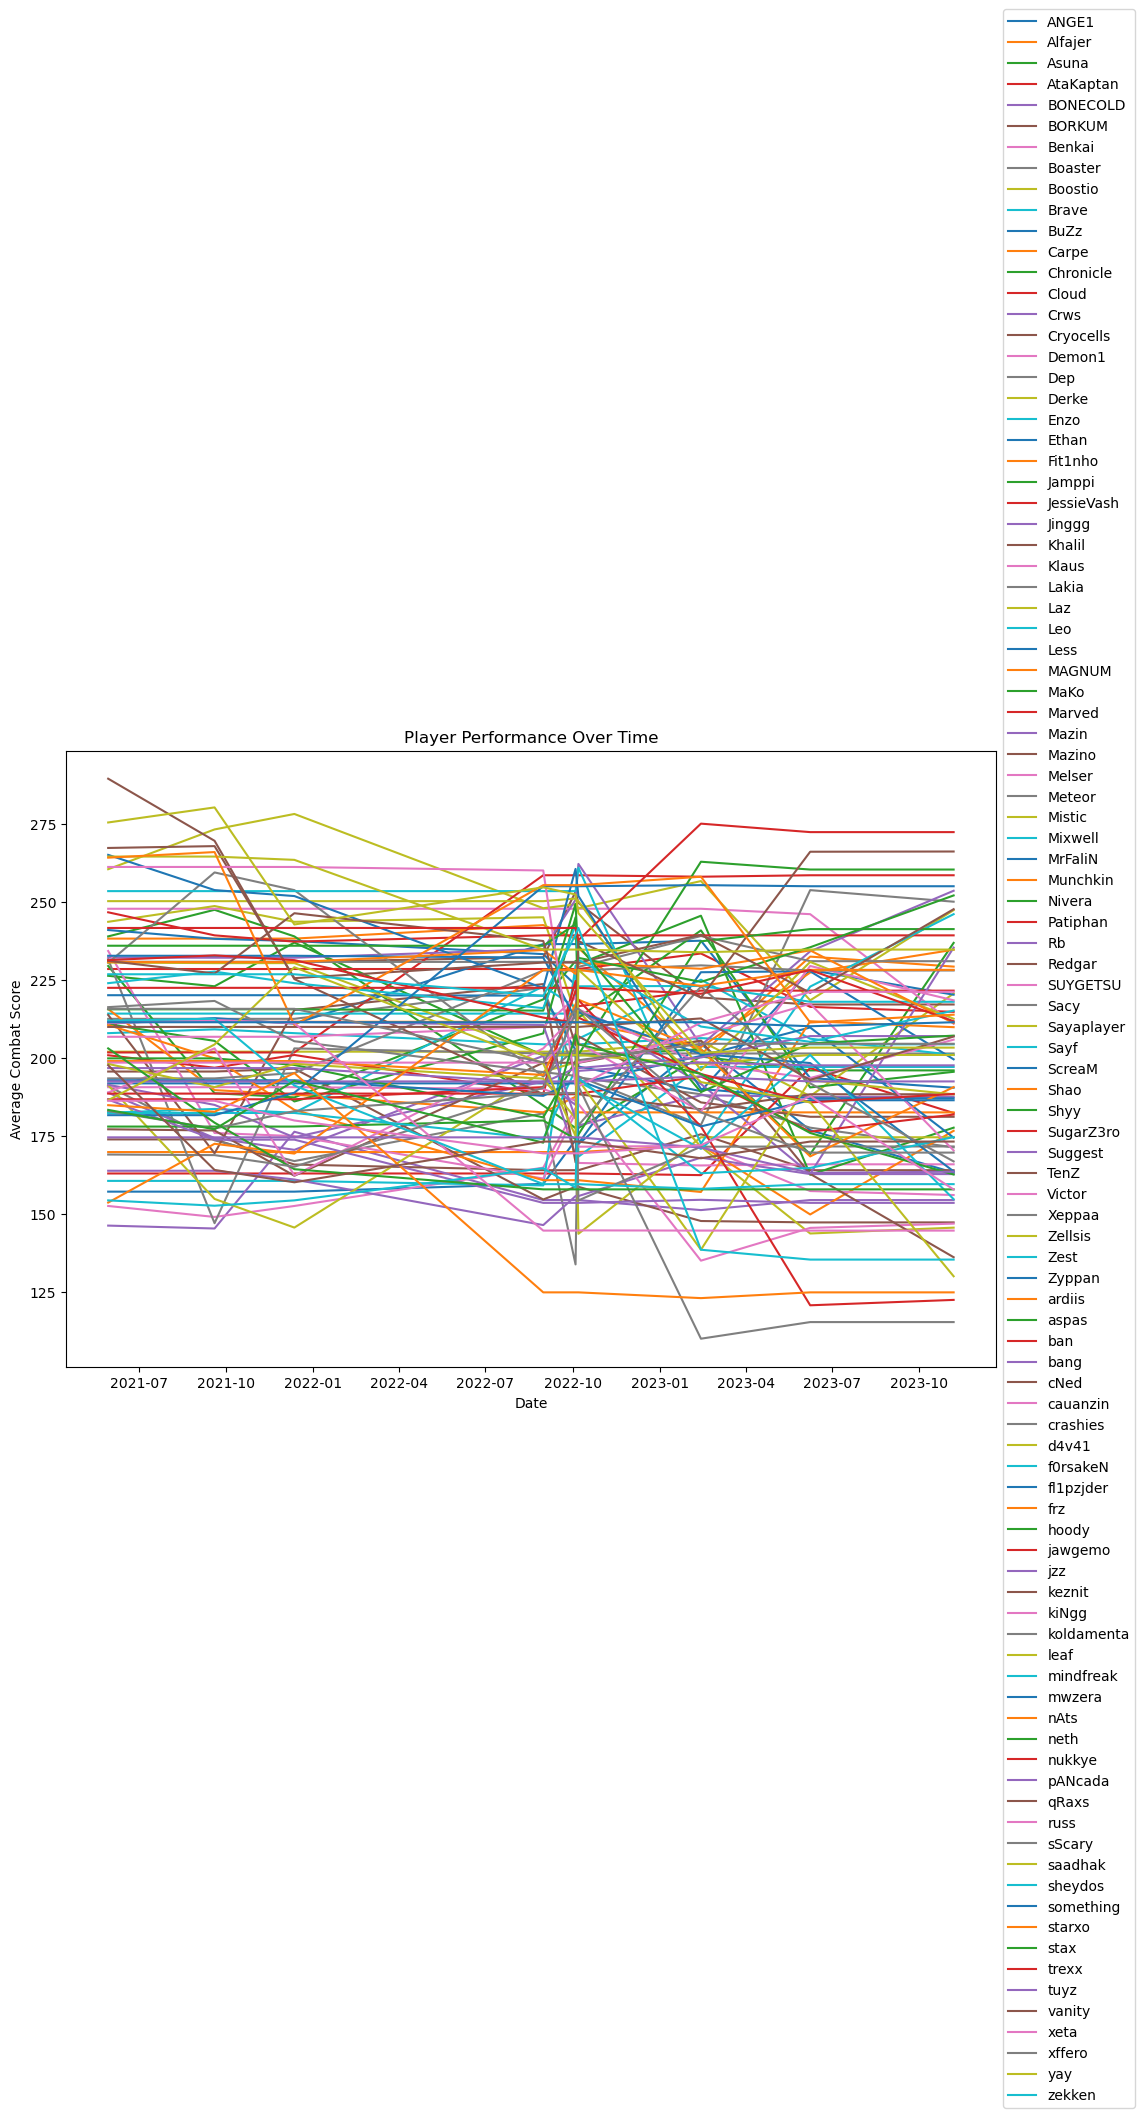

In [189]:
# Plot of all player performance over time

# Create a larger figure
fig, ax = plt.subplots(figsize=(12, 8))

# Plotting the performance of players from every tournament
for player_name, player_data in all_data_w_predict.groupby('player'):
    ax.plot(player_data['date'], player_data['average_combat_score'], label=player_name)

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Average Combat Score')
ax.set_title('Player Performance Over Time')

# Move the legend outside the plot box
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

In [126]:
data[['player', 'average_combat_score']].sort_values('average_combat_score', ascending=False).drop_duplicates(subset='player', keep='first').head(10)

,player,average_combat_score
118,TenZ,289.4
409,yay,280.2
152,Derke,278.1
207,trexx,275.0
176,cNed,267.8
40,keznit,266.0
252,nAts,265.9
198,ScreaM,265.0
134,leaf,263.4
197,Nivera,262.8


In [165]:
#Get ACS and stats of players at next tourney date
next_tourney_date = '2024/1/23'
players_tournament = pd.DataFrame({'player':players, 'date':next_tourney_date})
players_tournament['date'] = pd.to_datetime(players_tournament['date'])

In [166]:
players_tournament = playerStatPredictions(players_tournament)

In [167]:
#Top 10 players next tournament
players_tournament.sort_values('average_combat_score', ascending=False).head(10)

,player,date,kills_per_round,assists_per_round,average_damage_per_round,first_kills_per_round,first_deaths_per_round,headshot_percentage,clutch_success_percentage,total_kills,total_deaths,total_assists,total_first_kills,total_first_deaths,average_combat_score
51,trexx,2024-01-23,1.00,0.20,181.2,0.070000,0.09,0.320,0.000,46.0,27.0,9.0,3.0,4.0,272.286285
11,keznit,2024-01-23,0.88,0.23,175.8,0.210000,0.09,0.200,0.180,79.0,70.0,21.0,19.0,8.0,266.073761
48,Nivera,2024-01-23,0.90,0.36,158.7,0.900000,0.09,0.330,0.060,93.0,70.0,37.0,19.0,9.0,260.296021
93,JessieVash,2024-01-23,0.90,0.32,170.1,0.110000,0.13,0.310,0.100,71.0,67.0,25.0,9.0,10.0,258.464569
8,mwzera,2024-01-23,0.93,0.32,166.0,0.090000,0.07,0.200,0.220,71.0,54.0,24.0,7.0,5.0,254.948135
83,Jinggg,2024-01-23,0.86,0.23,166.5,0.140000,0.14,0.180,0.055,285.0,262.0,78.0,47.0,48.0,251.623764
94,Dep,2024-01-23,0.89,0.08,156.3,0.120000,0.08,0.280,0.000,70.0,65.0,6.0,6.0,4.0,249.996002
43,cNed,2024-01-23,0.85,0.22,157.3,0.220000,0.14,0.255,0.000,106.0,103.0,27.0,27.0,17.0,248.644043
37,Derke,2024-01-23,0.82,0.20,157.7,0.226667,0.22,0.220,0.380,173.0,147.0,43.0,51.0,47.0,241.293396
12,Shyy,2024-01-23,0.87,0.20,154.8,0.160000,0.02,0.210,0.150,109.0,79.0,25.0,20.0,3.0,241.216003


In [161]:
# Future dates for prediction
future_dates = ['2024-03-01', '2024-03-15', '2024-04-01']

In [162]:
multiple_player_tournament = all_players_date(future_dates)

In [163]:
multiple_player_tournament = playerStatPredictions(multiple_player_tournament)

In [164]:
#Note due to limitations in data. Future predictions are off.
multiple_player_tournament

,player,date,kills_per_round,assists_per_round,average_damage_per_round,first_kills_per_round,first_deaths_per_round,headshot_percentage,clutch_success_percentage,total_kills,total_deaths,total_assists,total_first_kills,total_first_deaths,average_combat_score
0,Cryocells,2024-03-01,0.75,0.25,137.5,0.13,0.18,0.18,0.00,131.0,130.0,54.0,23.0,32.0,217.063354
1,Cryocells,2024-03-15,0.75,0.25,137.5,0.13,0.18,0.18,0.00,131.0,130.0,54.0,23.0,32.0,217.063354
2,Cryocells,2024-04-01,0.75,0.25,137.5,0.13,0.18,0.18,0.00,131.0,130.0,54.0,23.0,32.0,217.063354
3,bang,2024-03-01,0.74,0.34,134.5,0.13,0.12,0.39,0.05,129.0,131.0,59.0,22.0,21.0,206.947983
4,bang,2024-03-15,0.74,0.34,134.5,0.13,0.12,0.39,0.05,129.0,131.0,59.0,22.0,21.0,206.947983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,yay,2024-03-15,0.75,0.15,127.4,0.15,0.12,0.29,0.08,67.0,54.0,13.0,13.0,11.0,203.243805
296,yay,2024-04-01,0.75,0.15,127.4,0.15,0.12,0.29,0.08,67.0,54.0,13.0,13.0,11.0,203.243805
297,hoody,2024-03-01,0.70,0.46,139.0,0.10,0.12,0.23,0.12,113.0,113.0,74.0,16.0,19.0,207.090927
298,hoody,2024-03-15,0.70,0.46,139.0,0.10,0.12,0.23,0.12,113.0,113.0,74.0,16.0,19.0,207.090927


In [124]:
multiple_player_tournament.sort_values('average_combat_score', ascending=False).head(10)

,player,date,kills_per_round,assists_per_round,average_damage_per_round,first_kills_per_round,first_deaths_per_round,headshot_percentage,clutch_success_percentage,total_kills,total_deaths,total_assists,total_first_kills,total_first_deaths,average_combat_score
154,trexx,2024-03-15,1.00,0.20,181.2,0.07,0.09,0.32,0.00,46.0,27.0,9.0,3.0,4.0,272.286285
155,trexx,2024-04-01,1.00,0.20,181.2,0.07,0.09,0.32,0.00,46.0,27.0,9.0,3.0,4.0,272.286285
153,trexx,2024-03-01,1.00,0.20,181.2,0.07,0.09,0.32,0.00,46.0,27.0,9.0,3.0,4.0,272.286285
35,keznit,2024-04-01,0.88,0.23,175.8,0.21,0.09,0.20,0.18,79.0,70.0,21.0,19.0,8.0,266.073761
34,keznit,2024-03-15,0.88,0.23,175.8,0.21,0.09,0.20,0.18,79.0,70.0,21.0,19.0,8.0,266.073761
33,keznit,2024-03-01,0.88,0.23,175.8,0.21,0.09,0.20,0.18,79.0,70.0,21.0,19.0,8.0,266.073761
144,Nivera,2024-03-01,0.90,0.36,158.7,0.90,0.09,0.33,0.06,93.0,70.0,37.0,19.0,9.0,260.296021
146,Nivera,2024-04-01,0.90,0.36,158.7,0.90,0.09,0.33,0.06,93.0,70.0,37.0,19.0,9.0,260.296021
145,Nivera,2024-03-15,0.90,0.36,158.7,0.90,0.09,0.33,0.06,93.0,70.0,37.0,19.0,9.0,260.296021
281,JessieVash,2024-04-01,0.90,0.32,170.1,0.11,0.13,0.31,0.10,71.0,67.0,25.0,9.0,10.0,258.464569
